<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/Trabajo_final_EF_FNB_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Buque,127.0m x 22.0m
Grúa,20.0 Toneladas @ 25.0m
Material,ASTM_A572


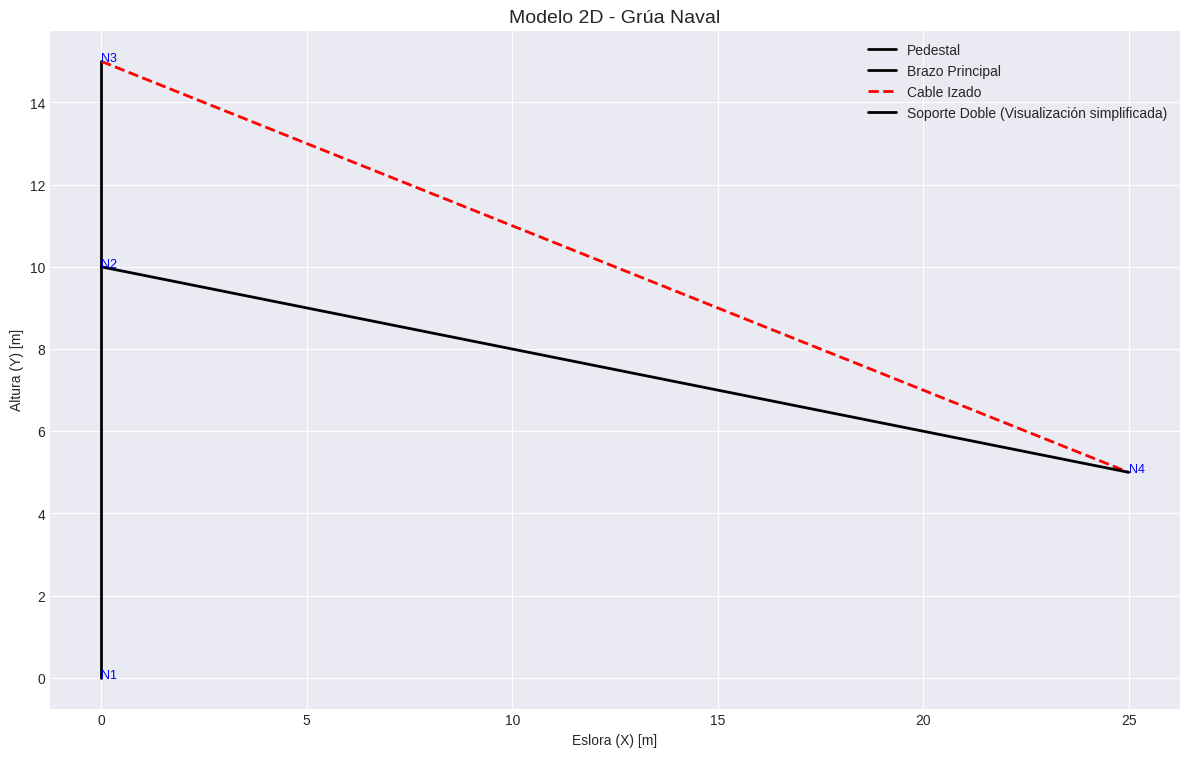

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.



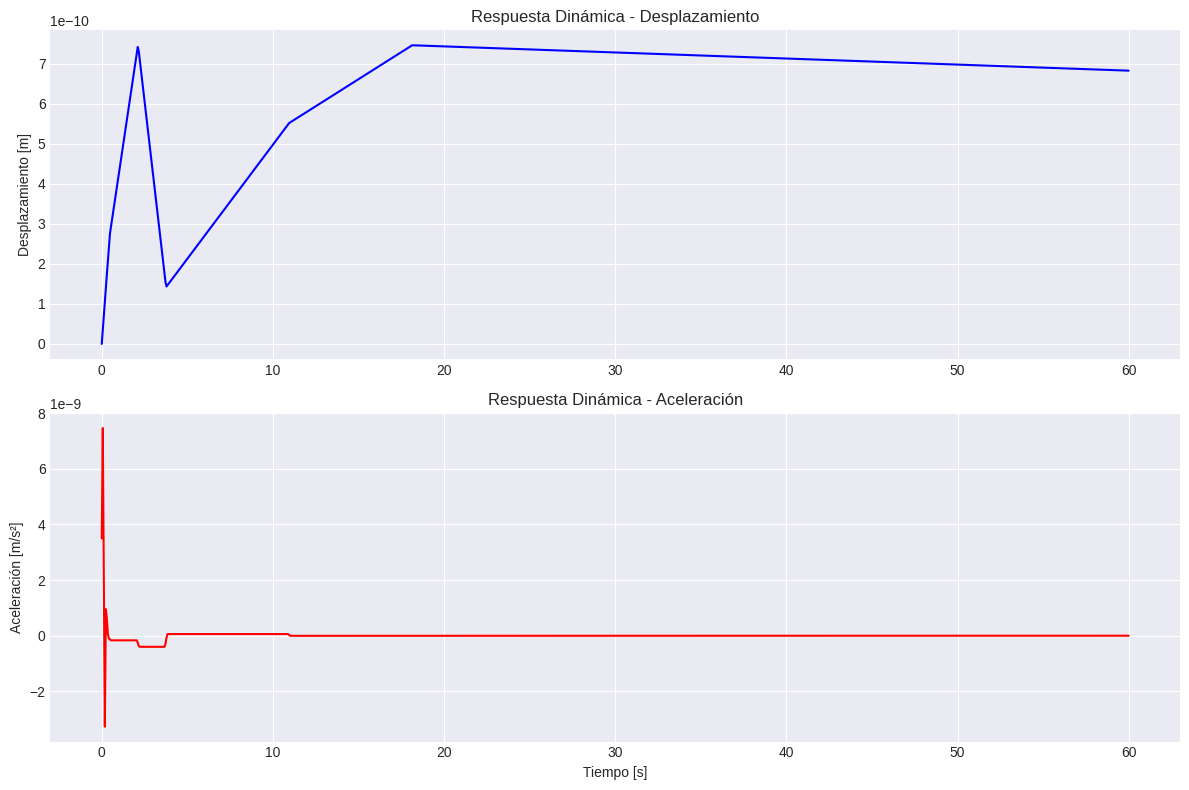

<ipython-input-10-dfe0cde97a6d>:471: UserWarning:

Glyph 128295 (\N{WRENCH}) missing from font(s) Liberation Sans.



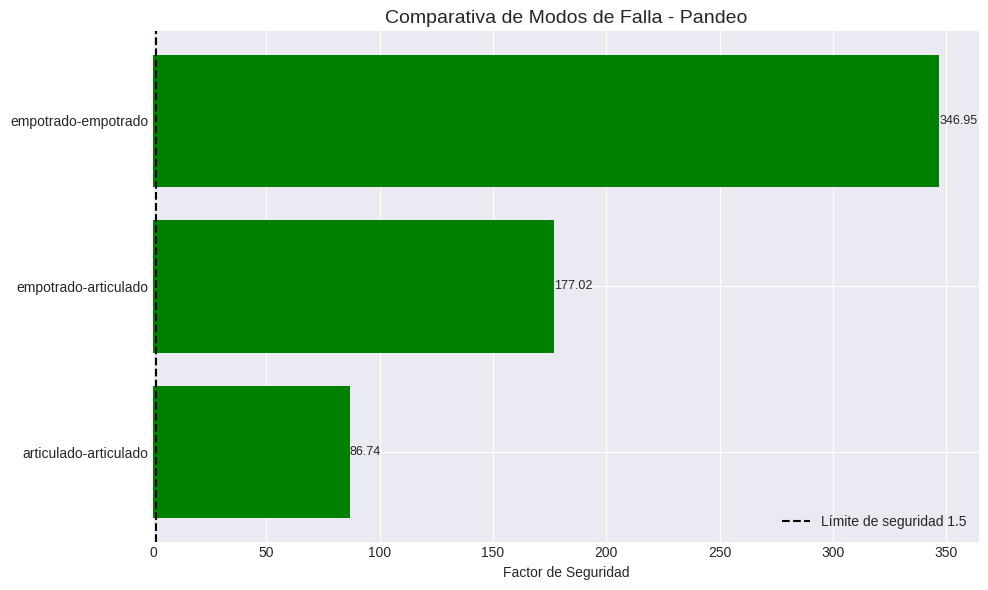

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128295 (\N{WRENCH}) missing from font(s) Liberation Sans.



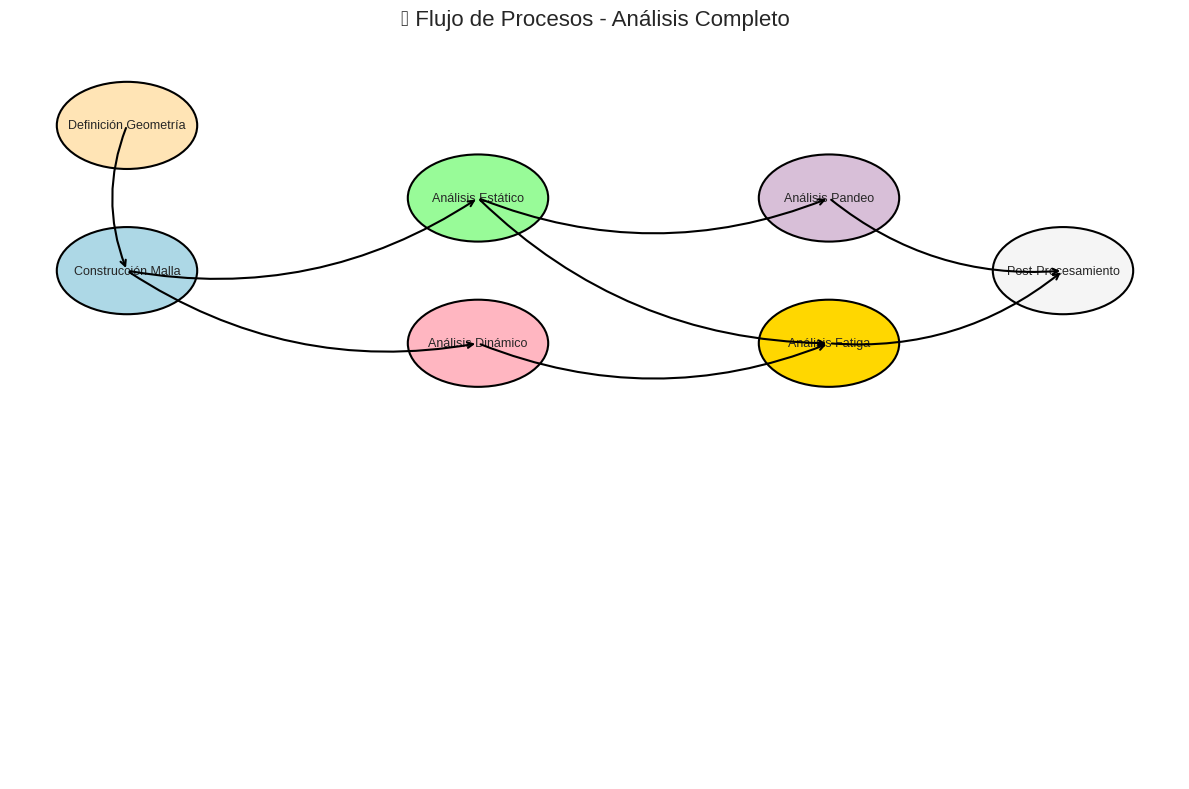

In [10]:
# =============================================================
# 🚀 ANÁLISIS DE GRÚA NAVAL - VERSIÓN 5.1 PROFESIONAL
# =============================================================

# 📚 SECCIÓN 1: CONFIGURACIÓN GLOBAL Y ESTRUCTURAS DE DATOS
# =============================================================

import numpy as np
import matplotlib.pyplot as plt
import logging
import json
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List
from enum import Enum
from pathlib import Path
import plotly.graph_objects as go
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import odeint
from IPython.display import display, HTML

# =============================================================
# ⚙️ Configuración inicial
# =============================================================

plt.style.use('seaborn-v0_8-darkgrid')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constantes físicas
GRAVEDAD = 9.80665  # m/s²
PI = np.pi

# =============================================================
# 🏗️ Definición de Materiales y Parámetros del Proyecto
# =============================================================

class Material(Enum):
    ASTM_A572 = {"E": 200e9, "rho": 7850, "sigma_y": 345e6, "S_fatiga": 250e6}

@dataclass
class ShipParams:
    eslora: float = 127.0  # m
    manga: float = 22.0    # m
    calado: float = 8.5    # m
    pos_grua: Tuple[float, float] = (18.7, 5.3)  # posición de la grúa sobre el buque
    tipo_buque: str = "Carga general"

@dataclass
class CraneParams:
    capacidad: float = 20.0      # ton
    longitud_brazo: float = 25.0 # m
    peso: float = 120.0          # ton
    material: Material = Material.ASTM_A572
    angulo_max: float = 270.0    # grados
    velocidad_izar: float = 0.5  # m/s

@dataclass
class EnviromentParams:
    ola_altura: float = 3.0      # m
    ola_periodo: float = 8.0     # s
    viento_velocidad: float = 15.0 # m/s

# =============================================================
# 📐 SECCIÓN 2: MODELADO GRÁFICO DE LA GRÚA
# =============================================================

class ModeladorGrafico:
    """Clase que genera visualizaciones 2D y 3D de la grúa naval."""

    def __init__(self, ship: ShipParams, crane: CraneParams):
        self.ship = ship
        self.crane = crane

    def modelo_2d_grua(self, show: bool = True) -> plt.Figure:
        """Crea un modelo 2D detallado de la grúa."""
        fig, ax = plt.subplots(figsize=(12, 8))

        # Definición de nodos en 2D
        nodos = {
            1: [0, 0],
            2: [0, 10],
            3: [0, 15],
            4: [25, 5]
        }

        # Elementos de la grúa
        elementos = {
            "Pedestal": (1, 2),
            "Brazo Principal": (2, 3),
            "Cable Izado": (3, 4),
            "Soporte Doble (Visualización simplificada)": (2, 4)
        }

        # Dibujar elementos
        for nombre, (ini, fin) in elementos.items():
            x = [nodos[ini][0], nodos[fin][0]]
            y = [nodos[ini][1], nodos[fin][1]]
            estilo = 'k-' if "Brazo" in nombre or "Pedestal" in nombre or "Soporte" in nombre else 'r--'
            ax.plot(x, y, estilo, lw=2, label=nombre)

        # Etiquetas de los nodos
        for idx, (x, y) in nodos.items():
            ax.text(x, y, f'N{idx}', fontsize=9, color='blue')

        ax.set_xlabel('Eslora (X) [m]')
        ax.set_ylabel('Altura (Y) [m]')
        ax.set_title('Modelo 2D - Grúa Naval', fontsize=14)
        ax.grid(True)
        ax.set_aspect('equal')
        plt.legend()
        plt.tight_layout()

        if show:
            plt.show()
        return fig

    def modelo_3d_grua(self) -> go.Figure:
        """Genera modelo 3D interactivo de la grúa con soporte doble."""
        nodos = {
            "N1": (0, 0, 0),
            "N2": (0, 0, 10),
            "N3": (0, 0, 15),
            "N4": (25, 5, 10),
            "N2_izq": (0, -0.5, 10),
            "N2_der": (0, 0.5, 10),
            "N4_izq": (25, 4.5, 10),
            "N4_der": (25, 5.5, 10)
        }

        elementos = [
            ("Pedestal", "N1", "N2", "black"),
            ("Brazo Vertical", "N2", "N3", "blue"),
            ("Cable Izado", "N3", "N4", "red"),
            ("Soporte Izquierdo", "N2_izq", "N4_izq", "green"),
            ("Soporte Derecho", "N2_der", "N4_der", "green")
        ]

        fig = go.Figure()

        for nombre, ini, fin, color in elementos:
            x = [nodos[ini][0], nodos[fin][0]]
            y = [nodos[ini][1], nodos[fin][1]]
            z = [nodos[ini][2], nodos[fin][2]]

            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode='lines+markers',
                marker=dict(size=5, color=color),
                line=dict(color=color, width=6, dash='solid' if "Cable" not in nombre else 'dash'),
                name=nombre
            ))

        fig.update_layout(
            title="Modelo 3D Grúa Naval con Soporte Doble (Versión 5.1)",
            scene=dict(
                xaxis_title="Eslora (X) [m]",
                yaxis_title="Manga (Y) [m]",
                zaxis_title="Altura (Z) [m]",
                aspectratio=dict(x=2, y=1, z=1)
            ),
            height=700,
            margin=dict(l=0, r=0, b=0, t=40)
        )

        return fig
# =============================================================
# 🏗️ SECCIÓN 3: ANÁLISIS ESTRUCTURAL FEM
# =============================================================

class AnalisisFEM:
    """Clase que implementa el Análisis Estructural mediante FEM para la grúa."""

    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value
        self.K = None  # Matriz global de rigidez
        self.F = None  # Vector de cargas
        self.u = None  # Vector de desplazamientos

    def construir_matriz_rigidez(self, n_nodos: int = 20):
        """Construye la matriz de rigidez global del sistema."""
        dof = n_nodos * 3  # 3 GDL por nodo (x, y, rotación)
        self.K = lil_matrix((dof, dof))

        # Propiedades de material
        E = self.material["E"]
        A = 0.1  # Área [m²]
        I = 0.01 # Momento de inercia [m⁴]
        L = self.crane.longitud_brazo / (n_nodos - 1)  # Longitud de cada elemento

        # Matriz local tipo beam 2D
        k_local = np.array([
            [E*A/L, 0, 0, -E*A/L, 0, 0],
            [0, 12*E*I/L**3, 6*E*I/L**2, 0, -12*E*I/L**3, 6*E*I/L**2],
            [0, 6*E*I/L**2, 4*E*I/L, 0, -6*E*I/L**2, 2*E*I/L],
            [-E*A/L, 0, 0, E*A/L, 0, 0],
            [0, -12*E*I/L**3, -6*E*I/L**2, 0, 12*E*I/L**3, -6*E*I/L**2],
            [0, 6*E*I/L**2, 2*E*I/L, 0, -6*E*I/L**2, 4*E*I/L]
        ])

        # Ensamblaje en la matriz global
        for i in range(n_nodos-1):
            start = i * 3
            end = (i+1) * 3
            self.K[start:end+3, start:end+3] += k_local

        logging.info(f"Matriz de rigidez construida ({dof}x{dof}) para {n_nodos} nodos.")
        return self.K

    def aplicar_cargas(self, carga_nodal: Dict[int, float]):
        """Aplica cargas nodales sobre el sistema."""
        dof = self.K.shape[0]
        self.F = np.zeros(dof)

        for nodo, carga in carga_nodal.items():
            pos = nodo * 3 + 1  # Carga en dirección Y (segundo GDL)
            if pos < dof:
                self.F[pos] = -carga  # Negativo porque actúa hacia abajo

        logging.info(f"Cargas aplicadas en {len(carga_nodal)} nodos.")
        return self.F

    def resolver(self, restricciones: List[int]) -> np.ndarray:
        """Resuelve el sistema FEM con condiciones de borde."""
        if self.K is None or self.F is None:
            raise ValueError("La matriz de rigidez o el vector de cargas no están definidos.")

        K_mod = self.K.tocsc()
        F_mod = self.F.copy()

        for dof in restricciones:
            if dof < K_mod.shape[0]:
                K_mod[dof, :] = 0
                K_mod[:, dof] = 0
                K_mod[dof, dof] = 1
                F_mod[dof] = 0

        self.u = spsolve(K_mod, F_mod)
        logging.info("Sistema FEM resuelto exitosamente.")
        return self.u

    def post_procesar(self) -> Dict:
        """Calcula esfuerzos máximos y factor de seguridad."""
        if self.u is None:
            raise ValueError("El sistema no ha sido resuelto.")

        deformacion_max = np.max(np.abs(self.u))
        esfuerzo_max = self.material["E"] * deformacion_max / self.crane.longitud_brazo
        fs_yield = esfuerzo_max / self.material["sigma_y"]

        return {
            "deformacion_max": deformacion_max,
            "esfuerzo_max": esfuerzo_max,
            "fs_yield": fs_yield,
            "estado": "✅ Seguro" if fs_yield < 1 else "⚠️ Riesgo"
        }
# =============================================================
# 🧩 SECCIÓN 4: ANÁLISIS DE PANDEO CRÍTICO
# =============================================================

class AnalisisPandeo:
    """Clase que calcula la carga crítica de pandeo para la grúa naval."""

    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def calcular_carga_critica(self, tipo_apoyo: str = "articulado") -> float:
        """Calcula la carga crítica de pandeo según el tipo de apoyo."""
        L = self.crane.longitud_brazo
        E = self.material["E"]
        I = self._inercia_aproximada()

        # Factores K para diferentes tipos de apoyo
        factores_K = {
            "articulado-articulado": 1.0,
            "empotrado-articulado": 0.7,
            "empotrado-empotrado": 0.5,
            "empotrado-libre": 2.0
        }

        K = factores_K.get(tipo_apoyo, 1.0)
        P_cr = (PI**2 * E * I) / ((K * L)**2)
        return P_cr

    def _inercia_aproximada(self) -> float:
        """Calcula un momento de inercia aproximado para sección tubular."""
        D_ext = 0.8  # Diámetro exterior [m]
        t = 0.03     # Espesor de pared [m]
        return (PI/64) * (D_ext**4 - (D_ext - 2*t)**4)

    def evaluar_pandeo(self, carga_aplicada: float) -> Dict:
        """Evalúa el riesgo de pandeo para diferentes condiciones de apoyo."""
        resultados = {}
        tipos_apoyo = [
            "articulado-articulado",
            "empotrado-articulado",
            "empotrado-empotrado"
        ]

        for tipo in tipos_apoyo:
            P_crit = self.calcular_carga_critica(tipo)
            factor_seguridad = P_crit / carga_aplicada
            resultados[tipo] = {
                "carga_critica": P_crit,
                "factor_seguridad": factor_seguridad,
                "estado": "✅ Estable" if factor_seguridad > 1.5 else "⚠️ Riesgo"
            }

        return resultados
# =============================================================
# 🌊 SECCIÓN 5: ANÁLISIS DINÁMICO (RESPUESTA A OLEAJE)
# =============================================================

class AnalisisDinamico:
    """Clase que simula la respuesta dinámica de la grúa sometida a oleaje."""

    def __init__(self, crane: CraneParams, env: EnviromentParams):
        self.crane = crane
        self.env = env
        self.material = crane.material.value

    def simular_respuesta(self, t_max: float = 60.0) -> Dict:
        """Simula la respuesta dinámica ante excitación de oleaje."""
        masa = self.crane.peso * 1000  # [kg]
        k = self.material["E"] * 0.01  # Rigidez simplificada [N/m]
        c = 0.1 * np.sqrt(k * masa)    # Amortiguamiento 10% del crítico

        # Función excitadora (oleaje)
        def excitacion(t):
            return (self.env.ola_altura / 2) * np.sin(2 * PI * t / self.env.ola_periodo)

        # Ecuación diferencial del sistema masa-resorte-amortiguador
        def ecuacion(u, t):
            x, v = u
            dxdt = v
            dvdt = (excitacion(t) - c*v - k*x) / masa
            return [dxdt, dvdt]

        # Integración temporal
        t = np.linspace(0, t_max, 1000)
        condiciones_iniciales = [0.0, 0.0]
        solucion = odeint(ecuacion, condiciones_iniciales, t)

        return {
            "tiempo": t,
            "desplazamiento": solucion[:, 0],
            "velocidad": solucion[:, 1],
            "aceleracion": np.gradient(solucion[:, 1], t)
        }

    def plot_resultados_dinamicos(self, resultados: Dict) -> plt.Figure:
        """Grafica desplazamiento y aceleración frente al tiempo."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

        # Gráfico de desplazamiento
        ax1.plot(resultados["tiempo"], resultados["desplazamiento"], 'b-')
        ax1.set_ylabel("Desplazamiento [m]")
        ax1.set_title("Respuesta Dinámica - Desplazamiento")
        ax1.grid(True)

        # Gráfico de aceleración
        ax2.plot(resultados["tiempo"], resultados["aceleracion"], 'r-')
        ax2.set_xlabel("Tiempo [s]")
        ax2.set_ylabel("Aceleración [m/s²]")
        ax2.set_title("Respuesta Dinámica - Aceleración")
        ax2.grid(True)

        plt.tight_layout()
        return fig
# =============================================================
# 🔄 SECCIÓN 6: ANÁLISIS DE FATIGA ESTRUCTURAL
# =============================================================

class AnalisisFatiga:
    """Clase para estimar la vida a fatiga de la estructura de la grúa naval."""

    def __init__(self, crane: CraneParams):
        self.crane = crane
        self.material = crane.material.value

    def estimar_vida(self, rango_esfuerzo: float, ciclos_por_año: int = int(1e6)) -> Dict:
        """
        Estima la vida útil bajo cargas cíclicas usando Ley de Basquin simplificada.

        Args:
            rango_esfuerzo (float): Rango de esfuerzo cíclico aplicado [Pa].
            ciclos_por_año (int): Número de ciclos de carga por año.

        Returns:
            Dict: Información sobre la vida estimada a fatiga.
        """
        S_f = self.material["S_fatiga"]

        # Aplicando fórmula simplificada de Basquin
        vida_ciclos = (S_f / (rango_esfuerzo/2)) ** 6
        vida_anios = vida_ciclos / ciclos_por_año

        return {
            "rango_esfuerzo": rango_esfuerzo,
            "vida_ciclos": vida_ciclos,
            "vida_anios": vida_anios,
            "estado": "✅ Adecuada" if vida_anios > 20 else "⚠️ Riesgo de fatiga"
        }
# =============================================================
# 🎨 SECCIÓN 7: VISUALIZACIONES PROFESIONALES
# =============================================================

class Visualizador:
    """Clase para crear visualizaciones avanzadas del análisis."""

    @staticmethod
    def plot_modos_falla(resultados: Dict) -> plt.Figure:
        """Genera un gráfico de barras de factores de seguridad por tipo de pandeo."""
        fig, ax = plt.subplots(figsize=(10, 6))

        modos = list(resultados.keys())
        factores = [v["factor_seguridad"] for v in resultados.values()]

        bars = ax.barh(modos, factores, color=["green" if fs > 1.5 else "red" for fs in factores])

        # Línea límite de seguridad
        ax.axvline(1.5, color="black", linestyle="--", label="Límite de seguridad 1.5")
        ax.set_xlabel("Factor de Seguridad")
        ax.set_title("Comparativa de Modos de Falla - Pandeo", fontsize=14)
        ax.legend()

        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.05, bar.get_y() + bar.get_height()/2,
                    f"{width:.2f}", ha='left', va='center', fontsize=9)

        plt.tight_layout()
        return fig

    @staticmethod
    def diagrama_flujo_proceso() -> plt.Figure:
        """Dibuja un diagrama de flujo profesional del proceso de análisis."""
        fig, ax = plt.subplots(figsize=(12,8))
        ax.axis('off')

        nodos = [
            {"texto": "Definición Geometría", "pos": (0.1, 0.9), "color": "#FFE4B5"},
            {"texto": "Construcción Malla", "pos": (0.1, 0.7), "color": "#ADD8E6"},
            {"texto": "Análisis Estático", "pos": (0.4, 0.8), "color": "#98FB98"},
            {"texto": "Análisis Dinámico", "pos": (0.4, 0.6), "color": "#FFB6C1"},
            {"texto": "Análisis Pandeo", "pos": (0.7, 0.8), "color": "#D8BFD8"},
            {"texto": "Análisis Fatiga", "pos": (0.7, 0.6), "color": "#FFD700"},
            {"texto": "Post-Procesamiento", "pos": (0.9, 0.7), "color": "#F5F5F5"}
        ]

        # Dibujar nodos
        for nodo in nodos:
            ax.add_patch(plt.Circle(nodo["pos"], 0.06, color=nodo["color"], ec="black", lw=1.5))
            ax.text(nodo["pos"][0], nodo["pos"][1], nodo["texto"],
                    ha='center', va='center', fontsize=9)

        # Conexiones
        conexiones = [
            (0, 1), (1, 2), (1, 3),
            (2, 4), (2, 5), (3, 5),
            (4, 6), (5, 6)
        ]

        for i, j in conexiones:
            ax.annotate("", xy=nodos[j]["pos"], xytext=nodos[i]["pos"],
                        arrowprops=dict(arrowstyle="->", lw=1.5, connectionstyle="arc3,rad=0.2"))

        ax.set_title("🔧 Flujo de Procesos - Análisis Completo", fontsize=16, pad=20)
        plt.tight_layout()
        return fig
# =============================================================
# 📤 SECCIÓN 8: EXPORTACIÓN DE RESULTADOS
# =============================================================

class ReportGenerator:
    """Clase que gestiona la exportación de resultados a formatos JSON y HTML."""

    @staticmethod
    def generar_reporte_html(resultados: Dict) -> str:
        """Genera un reporte en formato HTML a partir de los resultados del análisis."""
        html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <style>
                body {{ font-family: Arial, sans-serif; }}
                h1 {{ color: #2E86C1; }}
                table {{ width: 100%; border-collapse: collapse; }}
                th, td {{ padding: 10px; text-align: left; border-bottom: 1px solid #ddd; }}
                tr:hover {{ background-color: #f1f1f1; }}
            </style>
        </head>
        <body>
            <h1>Reporte de Análisis - Grúa Naval</h1>
            <h2>Resultados Principales</h2>
            <table>
                <tr><th>Parámetro</th><th>Valor</th></tr>
                <tr><td>Esfuerzo Máximo [Pa]</td><td>{resultados['fem']['esfuerzo_max']:.2f}</td></tr>
                <tr><td>Factor de Seguridad</td><td>{resultados['fem']['fs_yield']:.2f}</td></tr>
                <tr><td>Estado General</td><td>{resultados['fem']['estado']}</td></tr>
            </table>
            <h2>Análisis de Pandeo</h2>
            <table>
                <tr><th>Condición</th><th>Carga Crítica [N]</th><th>Factor Seguridad</th><th>Estado</th></tr>
        """
        for condicion, datos in resultados['pandeo'].items():
            html += f"""
                <tr>
                    <td>{condicion}</td>
                    <td>{datos['carga_critica']:.2f}</td>
                    <td>{datos['factor_seguridad']:.2f}</td>
                    <td>{datos['estado']}</td>
                </tr>
            """
        html += """
            </table>
        </body>
        </html>
        """
        return html

    @staticmethod
    def exportar_resultados(resultados: Dict, nombre_base: str = "reporte_grua"):
        """Exporta resultados tanto a archivo JSON como a HTML."""
        timestamp = np.datetime64("now").astype(str).replace(":", "-")
        json_path = Path(f"{nombre_base}_{timestamp}.json")
        html_path = Path(f"{nombre_base}_{timestamp}.html")

        # Exportar JSON
        with open(json_path, "w") as f_json:
            json.dump(resultados, f_json, indent=4)

        # Exportar HTML
        reporte_html = ReportGenerator.generar_reporte_html(resultados)
        with open(html_path, "w") as f_html:
            f_html.write(reporte_html)

        logging.info(f"Resultados exportados exitosamente: {json_path} y {html_path}")
        return json_path, html_path
# =============================================================
# 🧠 SECCIÓN 9: EJECUCIÓN PRINCIPAL DEL PROYECTO
# =============================================================

def main():
    """Función principal que ejecuta el flujo completo de análisis de la grúa naval."""
    logging.info("🚀 Iniciando Análisis Completo de la Grúa Naval...")

    # 1️⃣ Parámetros iniciales
    buque = ShipParams()
    grua = CraneParams()
    ambiente = EnviromentParams()

    NavalUtils.mostrar_tabla({
        "Buque": f"{buque.eslora}m x {buque.manga}m",
        "Grúa": f"{grua.capacidad} Toneladas @ {grua.longitud_brazo}m",
        "Material": grua.material.name
    }, "📋 Parámetros Iniciales")

    # 2️⃣ Modelado Gráfico
    modelador = ModeladorGrafico(buque, grua)
    modelador.modelo_2d_grua(show=True)
    fig_3d = modelador.modelo_3d_grua()
    fig_3d.show()

    # 3️⃣ Análisis Estructural FEM
    fem = AnalisisFEM(grua)
    fem.construir_matriz_rigidez()
    carga_nodal = {15: NavalUtils.toneladas_a_newton(grua.capacidad)}
    fem.aplicar_cargas(carga_nodal)
    desplazamientos = fem.resolver(restricciones=[0, 1, 2])  # Nodo base fijo
    resultados_fem = fem.post_procesar()

    # 4️⃣ Análisis de Pandeo
    pandeo = AnalisisPandeo(grua)
    resultados_pandeo = pandeo.evaluar_pandeo(NavalUtils.toneladas_a_newton(grua.capacidad))

    # 5️⃣ Análisis Dinámico
    dinamico = AnalisisDinamico(grua, ambiente)
    resultados_dinamico = dinamico.simular_respuesta()
    fig_dinamica = dinamico.plot_resultados_dinamicos(resultados_dinamico)
    plt.show()

    # 6️⃣ Análisis de Fatiga
    fatiga = AnalisisFatiga(grua)
    resultados_fatiga = fatiga.estimar_vida(rango_esfuerzo=resultados_fem["esfuerzo_max"] * 0.3)

    # 7️⃣ Visualizaciones
    visualizador = Visualizador()
    fig_modos = visualizador.plot_modos_falla(resultados_pandeo)
    fig_flujo = visualizador.diagrama_flujo_proceso()
    plt.show()

    # 8️⃣ Consolidar Resultados
    resultados_finales = {
        "ship": vars(buque),
        "crane": {**vars(grua), "material": grua.material.value},
        "fem": resultados_fem,
        "pandeo": resultados_pandeo,
        "dinamico": {
            "desplazamiento_max": np.max(resultados_dinamico["desplazamiento"]),
            "aceleracion_max": np.max(resultados_dinamico["aceleracion"])
        },
        "fatiga": resultados_fatiga
    }

    # 9️⃣ Exportar Resultados
    ReportGenerator.exportar_resultados(resultados_finales)

    logging.info("✅ Análisis completo finalizado exitosamente.")

# Ejecutar automáticamente si es el script principal
if __name__ == "__main__":
    main()
